In [ ]:
!pip install -U -q PyDrive          
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
os.chdir("C:\\Users\\utent\\Desktop\\PORTA\\modelli\\new_models\\12-14-15-16_17")
model=tf.keras.models.load_model('LSTM_12-14-15-16_17.h5')   
predictions = np.ravel(model.predict(X))

In [ ]:
downloaded = drive.CreateFile({'id':'1RFmMxpnJQ--ZMtBnXC7l8AYpyLk5Exhd'}) 
downloaded.GetContentFile('repository_conv_15-16_17.dat') 
downloaded = drive.CreateFile({'id':'1RFmMxpnJQ--ZMtBnXC7l8AYpyLk5Exhd'}) 
downloaded.GetContentFile('spett_new_15.dat')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import regularizers
from keras.layers import TimeDistributed
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Dropout
from numpy.linalg import norm
import matplotlib.pyplot as plt
import pickle
import time
import os

**`Definizione modelli`**





In [ ]:
#8
def model_conv_lstm(Tx,nh,nw,nchan,size_conv,size_lstm,size_dense,drop,drop_1,activations,size_stride):
      inputs =Input(shape=(Tx,nh,nw,nchan))                                                         #definisci la shape di input del modello
      X = TimeDistributed(Conv2D(int(nchan*size_conv)+1, 5, int(size_stride[0]),padding="same", activation=activations[0]))(inputs)  #applica ad input un layer convoluzonale con dimensione filtro 5, padding fatto in modo che ritorni alle dimensioni originali 
      X=Dropout(drop)(X)                  #termine di regolarizzazione
      X=BatchNormalization()(X)           #applica BatchNormailization a X
      X=TimeDistributed(MaxPool2D(2))(X)  #utilizza un time distributed MaxPooling con dimensione del filtro 2 (stride di 2 per default)
      X=TimeDistributed(Conv2D(int(nchan*size_conv*1.5),3,int(size_stride[1]), activation=activations[1]))(X)   # applica time distributed Conv2D in modo che gli weights siano gli stessi per tutti i Tx elementi
      X=Dropout(drop)(X)
      X=BatchNormalization()(X)
      X=TimeDistributed(MaxPool2D(3))(X) #utilizza un time distributed MaxPooling con dimensione del filtro 3 (stride di 3 per default)
      X=TimeDistributed(Conv2D(int(nchan*size_conv*2.25),3,int(size_stride[2]), activation=activations[2]))(X) # applica un ultimo time distributed Conv2D
      X=Dropout(drop)(X)
      X=BatchNormalization()(X)
      X =TimeDistributed(MaxPool2D(2))(X)
      X=TimeDistributed(Flatten())(X)                                            #appiattisci la matrice in modo che gli elementi possano essere input di LSTM
      X=LSTM(size_lstm,return_sequences=True)(X)                                 
      X=BatchNormalization()(X)
      X=Dropout(drop)(X)
      X = TimeDistributed(Dense(size_dense+1, activation = activations[3]))(X)   #applica un FF layer 
      X=BatchNormalization()(X)
      X=Dropout(drop_1)(X)
      outputs = TimeDistributed(Dense(1, activation = "linear"))(X)              #ritorna l'output finale 

      model = keras.Model(inputs=inputs, outputs=outputs)
      return model


def model_conv2D(nh,nw,nchan,size_conv,size_dense,drop,drop_1,activations,size_stride):
  inputs = Input(shape=(nh,nw,nchan))
  X = Conv2D(int(nchan*size_conv)+1, 5, int(size_stride[0]),padding="same", activation=activations[0])(inputs)
  X=Dropout(drop)(X)
  X=BatchNormalization()(X)
  X=MaxPool2D(2)(X)
  X = Conv2D(int(nchan*size_conv*1.5), 2, int(size_stride[1]), activation=activations[1])(X)
  X=Dropout(drop)(X)
  X = BatchNormalization()(X)
  X=MaxPool2D(3)(X)
  X = Conv2D(int(nchan*size_conv*2.25), 3, int(size_stride[2]),activation=activations[2])(X)
  X=Dropout(drop)(X)
  X = BatchNormalization()(X)
  X=MaxPool2D(2)(X)
  X = Flatten()(X)
  X = Dense(size_dense+1, activations[3])(X)
  X=Dropout(drop_1)(X)                                               
  X = BatchNormalization()(X)
  outputs=Dense(1, activation="linear")(X)

  model = keras.Model(inputs=inputs, outputs=outputs)

  return model

#modelli usati esclusivamente per debugging

def model_conv_lstm_v3(Tx,nh,nw,nchan):    
  drop=0.05
  inputs =Input(shape=(Tx,nh,nw,nchan))
  X = TimeDistributed(Conv2D(11, 5, 2,padding="same",activation='relu'))(inputs)
  X=Dropout(drop)(X)
  X=BatchNormalization()(X)
  X=TimeDistributed(MaxPool2D(2))(X)
  X=TimeDistributed(Conv2D(15,3,1, activation='relu'))(X)
  X=Dropout(drop)(X)
  X=BatchNormalization()(X)
  X=TimeDistributed(MaxPool2D(3))(X)
  X=TimeDistributed(Conv2D(22,3,2, activation='tanh'))(X)
  X=Dropout(drop)(X)
  X=BatchNormalization()(X)
  X = TimeDistributed(MaxPool2D(2))(X)
  X=TimeDistributed(Flatten())(X)
  X=LSTM(128,return_sequences=True)(X)
  X=BatchNormalization()(X)
  X=Dropout(0.025)(X)
  X = TimeDistributed(Dense(6, activation = "relu"))(X)
  X=BatchNormalization()(X)
  X=Dropout(0)(X)
  outputs = TimeDistributed(Dense(1, activation = "linear"))(X)

  model = keras.Model(inputs=inputs, outputs=outputs)
  return model
def model_conv_lstm_v4(Tx,nh,nw,nchan):    
  drop=0.05
  inputs =Input(shape=(Tx,nh,nw,nchan))
  X = TimeDistributed(Conv2D(10, 3, 1, activation='relu'))(inputs)
  X=Dropout(drop)(X)
  X=BatchNormalization()(X)
  X=TimeDistributed(MaxPool2D(2))(X)
  X=TimeDistributed(Conv2D(15,3,2, activation='relu'))(X)
  X=Dropout(drop)(X)
  X=BatchNormalization()(X)
  X=TimeDistributed(MaxPool2D(2))(X)
  X=TimeDistributed(Conv2D(20,3,3, activation='relu'))(X)
  X=Dropout(drop)(X)
  X=BatchNormalization()(X)
  X = TimeDistributed(MaxPool2D(3))(X)
  X=TimeDistributed(Flatten())(X)
  X=LSTM(64,return_sequences=True)(X)
  X=BatchNormalization()(X)
  X=Dropout(0)(X)
  outputs = TimeDistributed(Dense(1, activation = "linear"))(X)

  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

In [ ]:
#5
#seleziona il data_set giusto per il modello che voglio applicare
conv=1
if conv==1:
    with open("repository_conv_15-16_17.dat", "rb") as fp:
        [X_train,Y_train,X_test,Y_test]=pickle.load(fp)
    a,nh,nw,nch=X_train.shape
    
else:
    with open("repository_lstm_12-14-15-16-19_17-18.dat", "rb") as fp:
        [X_train,Y_train,X_test,Y_test]=pickle.load(fp)
    a,max_l, nh, nw, nch = X_train.shape
    model = model_conv_lstm_v3(max_l,nh,nw,nch)

pad=0

#Y_test=np.hstack((Y_test,np.zeros((1,40))))
#X_test=np.hstack((X_test,np.zeros((1,40,nh,nw,nch))))
#Y_train=np.hstack((Y_train,np.zeros((2,40))))
#X_train=np.hstack((X_train,np.zeros((2,40,nh,nw,nch))))
Y_train[Y_train==0]=pad
Y_test[Y_test==0]=pad
#Y_test=Y_test[:,0:130]
#X_test=X_test[:,0:130,:,:,:]
#Y_test=Y_test[:,20:150]
#X_test=X_test[:,20:150,:,:,:]
#Y_test=np.hstack((Y_test,np.zeros((1,20))))
#X_test=np.hstack((X_test,np.zeros((1,20,nh,nw,nch))))


**Definizione scores**

In [ ]:
#9
def norm_MAE(Y,predictions):
    real_predictions=predictions[Y!=pad]                                           #non considerare le predizioni sul padding a 0
    real_Y=Y[Y!=pad]
    MAE=np.average(np.abs(real_Y-real_predictions))
    mae=np.average(np.abs(real_Y-real_predictions))/(np.average(real_Y))                        
    return mae, MAE


def MAPE(Y,predictions):
    real_predictions=predictions[Y!=pad]                                           #non considerare le predizioni sul padding
    real_Y=Y[Y!=pad]
    mape=np.average(np.abs(real_Y-real_predictions)/np.abs(real_Y))                          
    return mape

#score che penalizza modelli che ritornano generalmente  RUL più elevata rispetto al groundtruth
def rel_score(Y,predictions):
    real_predictions=predictions[Y!=pad]
    real_Y=Y[Y!=pad]
    tot = (np.array([real_Y, real_predictions])).T                               #crea un vettore unico per poter gestre meglio il sorting
    tot=np.flipud(tot[tot[:,0].argsort()])                                       #fai il sorting rispetto alla prima colonna
    real_Y=tot[:,0]
    real_predictions=tot[:,1]
    range_=0.50
    vec=np.zeros(real_Y.size)
    for i in range (real_Y.size):
        vec[i]=np.power(1.1,i)                                                   #crea vettore di pesi che costituirà lo score

    x=(range_*(np.amax(vec)))/np.sum(vec)
    vec=x/vec
    vec=np.flip(vec)
    sum_score=0

    a=real_Y-real_predictions
    for i in range (real_Y.size):
        if a[i]<0:                                                               #caso negativo==> penalità
            sum_score=sum_score+vec[i]
    return sum_score

#definizione di uno score che valuta la deviazione standard dell'errore normalizzata
def norm_std(Y,predictions):
    real_predictions=predictions[Y!=pad]
    real_Y=Y[Y!=pad]
    err=np.abs(real_Y-real_predictions)
    graph=(err/real_Y)*100                                                       #salva in graph i valori che costitueranno un grafico
    std=np.std(err)
    prec=std/(np.average(real_Y))
    return prec,graph

#definizione Score che riassume i precedenti dando più importanza a MAPE
def agg_score(Y,predictions):
    w_mape=2/3
    w_prec=1/6
    w_rel_sc=1/6
    prec,graph=norm_std(Y,predictions)
    score=w_prec*prec+w_rel_sc*rel_score(Y,predictions)+w_mape*MAPE(Y,predictions)
    return score




**Definizione randomized_search**

In [ ]:
#7
#definizione parte 1 dell'algoritmo di ricerca
def randomized_search_1():
  #definisco alpha
  exp=-3*np.random.rand()-1
  alpha=np.power(10,exp)                          
  #definisco layer conv_size
  size_conv=np.random.rand()+1                     #numero tra 1 e 2 che mi ingrandisce il numero di unità in tutti i layer convoluzionali di conseguenza (vedi la cella modelli)
  #definisco lstm size
  size_lstm=np.random.choice([16,32,64,128])       #seleziona a random tra una di queste dimensioni per LSTM
  #definisco dense size
  size_dense=int(np.abs((np.random.normal(10,2))))  
  #definisco dropout rate
  choice=np.random.rand()
  if choice<0.5:                                  # il dropout o è nullo oppure è randomico tra 0 e 1
    drop=0
  else:
    drop=np.random.rand()
  if drop==0:
    drop_1=0
  else:
    drop_1=np.abs(drop-0.1)                      #il dropout per l'ultimo layer è leggermente inferiore
  #definisco activation
  activations=np.random.choice(["relu","tanh"],4)                        #le activation possono essere o relu o tanh
  #definisco epochs
  epo=int(np.random.uniform(400,900))
  #definisco stride size
  size_stride=np.random.choice([1,2],3)
  return alpha, size_conv, size_lstm,size_dense, drop, drop_1, activations, epo, size_stride

def randomized_search_2(alpha_1, size_conv_1,size_dense_1, drop_1, activations_1, epo_1):
  #definisco alpha
  alpha=np.random.uniform(0.5*alpha_1,1.5*alpha_1 )
  #definisco layer conv_size
  size_conv=np.abs(np.random.normal(size_conv_1,0.2))
  #definisco layer dense_size
  size_dense=int(np.abs((np.random.normal(size_dense_1,1))))
  #definisco dropout rate
  if drop_1==0:
    drop=np.random.rand()
  else:
    drop=np.random.uniform(0.9*drop_1,1.1*drop_1)
    if drop>=1:                                            #gestione di posibili valori di dropout non consentiti
      drop=0.95
  
  drop_1_1=np.abs(drop-0.1)
  #definisco activation
  if np.sum(activations_1=='relu')>2:
    activations=np.random.choice(["relu","tanh"],4,p=[0.7,0.3]) 
  elif np.sum(activations_1=='relu')==2:
    activations=activations_1
  else:
    activations=np.random.choice(["relu","tanh"],4,p=[0.3,0.7])
  #definisco epochs
  epo=int(np.random.uniform(0.85*epo_1,1.15*epo_1))
  if epo>1000:                                           #gestione di possibili valori di epochs troppo elevate
    epo=1000
  return alpha,size_conv,size_dense,drop,drop_1_1,activations,epo


  


**Faccio il training del modello**

In [ ]:
#cella usata esclusivamente per debugging
opt = keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='MSE')
history=model.fit(X_train,Y_train,batch_size=5,epochs=1000,verbose=1)


Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 11682.8496
Epoch 2/1000
1/1 [==============================] - 0s 191ms/step - loss: 11633.6709
Epoch 3/1000
1/1 [==============================] - 0s 201ms/step - loss: 11530.6260
Epoch 4/1000
1/1 [==============================] - 0s 208ms/step - loss: 11474.4805
Epoch 5/1000
1/1 [==============================] - 0s 205ms/step - loss: 11435.6514
Epoch 6/1000
1/1 [==============================] - 0s 189ms/step - loss: 11405.8330
Epoch 7/1000
1/1 [==============================] - 0s 206ms/step - loss: 11376.9209
Epoch 8/1000
1/1 [==============================] - 0s 210ms/step - loss: 11359.1445
Epoch 9/1000
1/1 [==============================] - 0s 193ms/step - loss: 11347.5127
Epoch 10/1000
1/1 [==============================] - 0s 197ms/step - loss: 11331.8945
Epoch 11/1000
1/1 [==============================] - 0s 193ms/step - loss: 11320.7783
Epoch 12/1000
1/1 [==============================] - 0s 189ms/step

1.7202839472739593
0.18511024870958
0.4999038770522718
  
1.2610249858096148


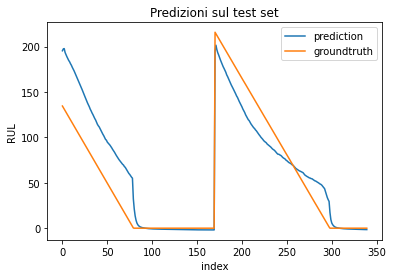

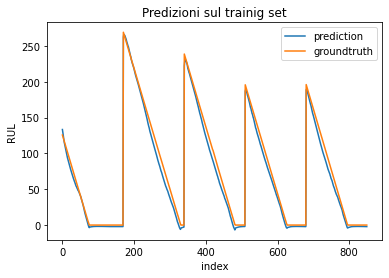

0.2699726270994032


In [ ]:
#cella usata esclusivamente per debugging

predictions=np.ravel(model.predict(X_test))
if conv==1:                                                                   
  predictions=predictions[np.flip(Y_test.argsort())]
  Y_test=np.flip(np.sort(Y_test))
#stampa 3 statistiche di interesse e lo Score
print(MAPE(np.ravel(Y_test),predictions))
prec,graph=norm_std(np.ravel(Y_test),predictions)
print(prec)
print(rel_score(np.ravel(Y_test),predictions))
print("  ")
print(agg_score(np.ravel(Y_test),predictions))
#stampa il grafico di predizioni sul test set
plt.plot(predictions,label="prediction")
plt.plot(np.ravel(Y_test),label="groundtruth")
plt.legend()
plt.ylabel('RUL')
plt.xlabel('index')
plt.title('Predizioni sul test set')
plt.show()
print(" ")

#stampa il grafico di predizioni sul training set
predictions_tr=np.ravel(model.predict(X_train))
plt.plot(predictions_tr,label="prediction")
plt.plot(np.ravel(Y_train),label="groundtruth")
plt.legend()
plt.ylabel('RUL')
plt.xlabel('index')
plt.title('Predizioni sul trainig set')
plt.show()

print(MAPE(np.ravel(Y_train),predictions_tr))

#prec,graph=norm_std(np.ravel(Y_train),predictions_tr)
#plt.plot(graph[graph<500])

**Esegui local-search per modello convoluzionale con LSTM**

In [ ]:
#6
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive
min_score=100                                                                    
i=1
flag=True
start=time.time()
if conv==0:
  while(time.time()-start<10800 and i<130):                                      #esegui parte 1 fino a quando sono passate 10800 sec oppure ho valutato più di 130 modelli                                      
    print(i)                                                                      
    if i%10==0:                                                                   #righe di codice usate solo per controllare durante l'esecuzione
      print("il MAPE vale ",MAPE(np.ravel(Y_test),np.ravel(model.predict(X_test))))
      print("L'agg score vale ",agg_score(np.ravel(Y_test),np.ravel(model.predict(X_test))))
      print(alpha)
      print(size_lstm)
      print(size_dense)
    while flag==True:
      try:                                                                       #prova a scegliere a random parametri
        alpha, size_conv, size_lstm,size_dense, drop, drop_1, activations, epo, size_stride=randomized_search_1()
        model = model_conv_lstm(max_l,nh,nw,nch,size_conv,size_lstm,size_dense,drop,drop_1,activations,size_stride)
        flag=False
      except:                                                                    #nel caso in cui non ci riesca per incongruenze nelle dimensioni del modello==>riprova
        flag=True
    flag=True
    opt = keras.optimizers.Adam(learning_rate=alpha)
    model.compile(optimizer=opt, loss='mean_squared_error')
    history=model.fit(X_train,Y_train,batch_size=5,epochs=epo,verbose=0)          #fai il training    
    i=i+1
    predictions=np.ravel(model.predict(X_test))
    if agg_score(np.ravel(Y_test),predictions)<min_score:
      min_score=agg_score(np.ravel(Y_test),predictions)
      alpha_1, size_conv_1, size_lstm_1,size_dense_1, drop_1, drop_1_1, activations_1, epo_1, size_stride_1=alpha, size_conv, size_lstm,size_dense,drop, drop_1, activations, epo, size_stride
      model.save('LSTM_part_12-14-15-16-19_17-18.h5')                                      #se ho trovato un modello di buona qualità, salvalo in drive con formato .h5
    
  i=1     
  start=time.time() 
  while(time.time()-start<7200 and i <90):                                        #esegui parte 2 fino a quando sono passati 7200 sec oppure ho valutato più di 90 modelli 
    print(i)
    if i%10==0:
      print("il MAPE vale ",MAPE(np.ravel(Y_test),np.ravel(model.predict(X_test))))
      print("L'agg score vale ",agg_score(np.ravel(Y_test),np.ravel(model.predict(X_test))))
      print(alpha)
      print(size_lstm)
      print(size_dense)
    alpha, size_conv,size_dense, drop, drop_1, activations, epo=randomized_search_2(alpha_1, size_conv_1,size_dense_1, drop_1,activations_1, epo_1)
    model= model_conv_lstm(max_l,nh,nw,nch,size_conv,size_lstm_1,size_dense,drop,drop_1,activations,size_stride_1)
    opt = keras.optimizers.Adam(learning_rate=alpha)
    model.compile(optimizer=opt, loss='mean_squared_error')
    history=model.fit(X_train,Y_train,batch_size=5,epochs=epo,verbose=0)

    i=i+1
    predictions=np.ravel(model.predict(X_test))
    if agg_score(np.ravel(Y_test),predictions)<min_score:
      min_score=agg_score(np.ravel(Y_test),predictions)
      alpha_1, size_conv_1, size_lstm_1,size_dense_1, drop_1, drop_1_1, activations_1, epo_1, size_stride_1=alpha, size_conv, size_lstm_1,size_dense,drop, drop_1, activations, epo, size_stride_1
      model.save('LSTM_12-14-15-16-19_17-18.h5')


Mounted at /gdrive
/gdrive/My Drive
1
2
3
4
5
6
7
8
9
10
il MAPE vale  1.6920166085803745
L'agg score vale  1.2477983966595296
0.01882473802108097
32
9
11
12
13
14
15
16
17
18
19
20
il MAPE vale  3.6365890652767394
L'agg score vale  2.562130187169243
0.009410790545823366
64
8
21
22
23
24
25
26
27
28
29
30
il MAPE vale  1.4544225481301345
L'agg score vale  1.0964368728551532
0.0014974191742656326
32
10
31
32
33
34
35
36
37
38
39
40
il MAPE vale  8.061551431915184
L'agg score vale  5.55111477295018
0.048232719769105856
64
8
41
42
43
44
45
46
47
48
49
50
il MAPE vale  1.1630555790453996
L'agg score vale  0.8332141870548031
0.009470316987631691
32
9
51
52
53
54
55
56
57
58
59
60
il MAPE vale  1.8858537432080131
L'agg score vale  1.349447878761301
0.0016122698133444976
64
10
61
62
63
64
65
66
67
68
69
1
2
3
4
5
6
7
8
9
10
il MAPE vale  0.7516448231051283
L'agg score vale  0.6112867409976155
0.026585578928126657
32
12
11
12
13
14
15
16
17
18
19
20
il MAPE vale  1.708834765783887
L'agg score 

KeyboardInterrupt: ignored

**Esegui local-search per modello covoluzionale** 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive
min_score=100
i=1
flag=True
start=time.time()
if conv==1:
  while(time.time()-start<10800 and i<130):   
    print(i)
    if i%10==0:
      print("il MAPE vale ",MAPE(np.ravel(Y_test),np.ravel(model.predict(X_test))))
      print("L'agg score vale ",agg_score(np.ravel(Y_test),np.ravel(model.predict(X_test))))
    while flag==True:
      try:
        alpha, size_conv, size_lstm,size_dense, drop, drop_1, activations, epo, size_stride=randomized_search_1()
        model = model_conv2D(nh,nw,nch,size_conv,size_dense,drop,drop_1,activations,size_stride)
        flag=False
      except:
        flag=True
    flag=True
    opt = keras.optimizers.Adam(learning_rate=alpha)
    model.compile(optimizer=opt, loss='MAPE')
    history=model.fit(X_train,Y_train,batch_size=64,epochs=epo,verbose=0)
    i=i+1
    predictions=np.ravel(model.predict(X_test))
    if agg_score(np.ravel(Y_test),predictions)<min_score:
      min_score=agg_score(np.ravel(Y_test),predictions)
      alpha_1, size_conv_1, size_lstm_1,size_dense_1, drop_1, drop_1_1, activations_1, epo_1, size_stride_1=alpha, size_conv, size_lstm,size_dense,drop, drop_1, activations, epo, size_stride
      model.save('conv_part_15-16_14.h5') 
  i=1    
  start=time.time() 
  while(time.time()-start<7200 and i<90): 
    print(i)
    if i%10==0:
      print("il MAPE vale ",MAPE(np.ravel(Y_test),np.ravel(model.predict(X_test))))
      print("L'agg score vale ",agg_score(np.ravel(Y_test),np.ravel(model.predict(X_test))))
    alpha, size_conv,size_dense, drop, drop_1, activations, epo=randomized_search_2(alpha_1, size_conv_1,size_dense_1, drop_1,activations_1, epo_1)
    model= model_conv2D(nh,nw,nch,size_conv,size_dense,drop,drop_1,activations,size_stride_1)
    opt = keras.optimizers.Adam(learning_rate=alpha)
    model.compile(optimizer=opt, loss='MAPE')
    history=model.fit(X_train,Y_train,batch_size=64,epochs=epo,verbose=0)
    i=i+1
    predictions=np.ravel(model.predict(X_test))
    if agg_score(np.ravel(Y_test),predictions)<min_score:
      min_score=agg_score(np.ravel(Y_test),predictions)
      alpha_1, size_conv_1, size_lstm_1,size_dense_1, drop_1, drop_1_1, activations_1, epo_1, size_stride_1=alpha, size_conv, size_lstm_1,size_dense,drop, drop_1, activations, epo, size_stride_1
      model.save('conv_15-16_14.h5')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive

Mounted at /gdrive
/gdrive/My Drive


**Stampo statistiche per modello migliore trovato**

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive
1.0381188730208257
0.32520034174656254
0.46681384558495415
  
0.8240816132358033


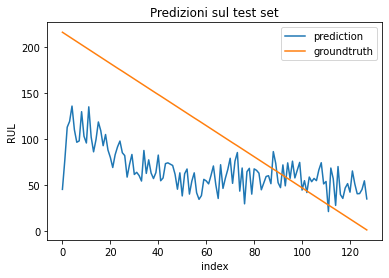

 
il MAE vale  55.743544373512265


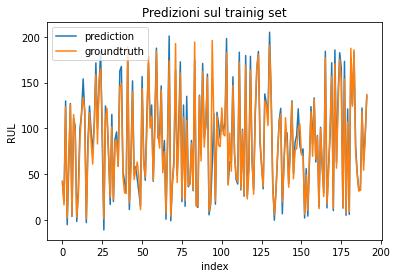

0.2260008516922248
 


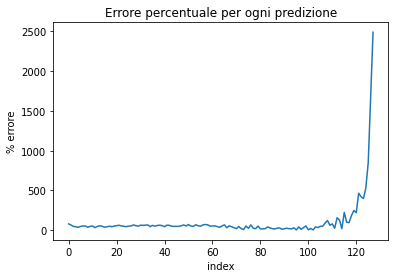

In [ ]:
#10
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive       
best_model=tf.keras.models.load_model('conv_15-16_14(2).h5')                     #riprendi da drive il modello migliore
#keras.utils.plot_model(best_model, "best_model.png", show_shapes=True)
predictions=np.ravel(best_model.predict(X_test))
predictions[predictions<0]=0                                                     #se prevedo un numero negativo==> fallo diventare nullo per consistenza
if conv==1:                                                                      #riordina i dati del test set 
  predictions=predictions[np.flip(Y_test.argsort())]
  Y_test=np.flip(np.sort(Y_test))
#stampa 3 statistiche di interesse e lo Score
print(MAPE(np.ravel(Y_test),predictions))
prec,graph=norm_std(np.ravel(Y_test),predictions)
print(prec)
print(rel_score(np.ravel(Y_test),predictions))
print("  ")
print(agg_score(np.ravel(Y_test),predictions))
#stampa il grafico di predizioni sul test set
plt.plot(predictions,label="prediction")
plt.plot(np.ravel(Y_test),label="groundtruth")
plt.legend()
plt.ylabel('RUL')
plt.xlabel('index')
plt.title('Predizioni sul test set')
plt.show()
print(" ")
mae,MAE=norm_MAE(np.ravel(Y_test),predictions)
print("il MAE vale ",MAE)
if conv==0:
  for i in range (a):  #stampa grafici di predizioni sul training set se LSTM
    predictions_tr=np.ravel(best_model.predict(X_train)[i,:,:])
    plt.plot(predictions_tr,label="prediction")
    plt.plot(np.ravel(Y_train[i,:]),label="groundtruth")
    plt.legend()
    plt.ylabel('RUL')
    plt.xlabel('index')
    plt.show()
if conv==1:             #stampa grafici di predizioni sul training set se convoluzionale
  predictions_tr=np.ravel(best_model.predict(X_train))
  plt.plot(predictions_tr,label="prediction")
  plt.plot(np.ravel(Y_train),label="groundtruth")
  plt.legend()
  plt.ylabel('RUL')
  plt.xlabel('index')
  plt.title('Predizioni sul trainig set')
  plt.show()
  
predictions_tr=np.ravel(best_model.predict(X_train))
print(MAPE(np.ravel(Y_train),predictions_tr))
print(" ")

plt.plot(graph)
plt.ylabel('% errore')
plt.xlabel('index')
plt.title('Errore percentuale per ogni predizione')
plt.show()

 **Faccio il re-training**
 
 Cella necessaria nel momento in cui voglio esaminare come cala la funzione costo all'aumentare delle epochs in fase di training

In [ ]:
#11
if conv==0:
  batch=2
else:
  batch=64
best_model_training=keras.models.clone_model(best_model)
alpha=(best_model.optimizer.get_config()).get("learning_rate")
opt = keras.optimizers.Adam(learning_rate=alpha)
best_model_training.compile(optimizer=opt, loss='mean_squared_error')
history=best_model_training.fit(X_train,Y_train,batch_size=batch,epochs=500,verbose=0)
loss=history.history['loss']
epochs=range(1, len(loss)+1)
plt.plot(epochs,loss)
plt.ylabel('Training loss (MSE)')
plt.xlabel('epochs')
plt.show()

**Recupero parametri migliore modello se LSTM**

Recupera i parametri migliori impostati dall'algorimo di ricerca

In [ ]:
#11
if conv==0:
  list_layer=list((best_model.get_config()).get('layers'))
  activ=[]; filt=[]; strid=[]; rate=[]; uni_lstm=0; uni_dense=0
  #1 conv 2d
  activ=activ+[((((list_layer[1]).get('config')).get('layer')).get('config')).get('activation')]
  filt=filt+[((((list_layer[1]).get('config')).get('layer')).get('config')).get('filters')]
  strid=strid+[((((list_layer[1]).get('config')).get('layer')).get('config')).get('strides')]

  #1 dropout
  rate=rate+[((list_layer[2]).get('config')).get('rate')]

  #2 conv 2d
  activ=activ+[((((list_layer[5]).get('config')).get('layer')).get('config')).get('activation')]
  filt=filt+[((((list_layer[5]).get('config')).get('layer')).get('config')).get('filters')]
  strid=strid+[((((list_layer[5]).get('config')).get('layer')).get('config')).get('strides')]

  #3 conv 2d
  activ=activ+[((((list_layer[9]).get('config')).get('layer')).get('config')).get('activation')]
  filt=filt+[((((list_layer[9]).get('config')).get('layer')).get('config')).get('filters')]
  strid=strid+[((((list_layer[9]).get('config')).get('layer')).get('config')).get('strides')]

  #LSTM
  uni_lstm=((list_layer[14]).get('config')).get('units')
  #2 dropout
  rate=rate+[((list_layer[19]).get('config')).get('rate')]
  #1 dense
  uni_dense=((((list_layer[17]).get('config')).get('layer')).get('config')).get('units')
  activ=activ+[((((list_layer[17]).get('config')).get('layer')).get('config')).get('activation')]

  alpha=(best_model.optimizer.get_config()).get("learning_rate")



**Recupero parametri migliore modello se solo convoluzionale**

Recupera i parametri migliori impostati dall'algorimo di ricerca

In [ ]:
if conv==1:
  list_layer=list((best_model.get_config()).get('layers'))
  activ=[]; filt=[]; strid=[]; rate=[]; uni_lstm=0; uni_dense=0
  #1 conv 2d
  activ=activ+[((list_layer[1]).get('config')).get('activation')]
  filt=filt+[((list_layer[1]).get('config')).get('filters')]
  strid=strid+[((list_layer[1]).get('config')).get('strides')]

  #1 dropout
  rate=rate+[((list_layer[2]).get('config')).get('rate')]

  #2 conv 2d
  activ=activ+[((list_layer[5]).get('config')).get('activation')]
  filt=filt+[((list_layer[5]).get('config')).get('filters')]
  strid=strid+[((list_layer[5]).get('config')).get('strides')]

  #3 conv 2d
  activ=activ+[((list_layer[9]).get('config')).get('activation')]
  filt=filt+[((list_layer[9]).get('config')).get('filters')]
  strid=strid+[((list_layer[9]).get('config')).get('strides')]
  #1 dense
  uni_dense=((list_layer[14]).get('config')).get('units')
  activ=activ+[((list_layer[14]).get('config')).get('activation')]
  #2 dropout
  rate=rate+[((list_layer[15]).get('config')).get('rate')]

  alpha=(best_model.optimizer.get_config()).get("learning_rate")

In [ ]:
#cosine_similarity example
cos_sim= np.dot(a, b)/(norm(a)*norm(b))
cos_sim